In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [3]:
# Load dataset from Hugging Face
splits = {'train': 'data/train-00000-of-00001-036257a1398b1fca.parquet', 
          'validation': 'data/validation-00000-of-00001.parquet', 
          'test': 'data/test-00000-of-00001-be9beacde3979e29.parquet', 
          'dev': 'data/dev-00000-of-00001-8c45b6a8f685b4bd.parquet'}
data = pd.read_parquet("hf://datasets/affahrizain/jigsaw-toxic-comment/" + splits["train"])

In [4]:
# Explore the dataset structure
print("Dataset shape:", data.shape)
print("\nColumn names:")
print(data.columns.tolist())
print("\nFirst few rows:")
print(data.head())

Dataset shape: (159100, 2)

Column names:
['labels', 'comment_clean']

First few rows:
   labels                                      comment_clean
0       0  explanation why the edits made under my userna...
1       0  d aww he matches this background colour i am s...
2       0  hey man i am really not trying to edit war it ...
3       0  more i cannot make any real suggestions on imp...
4       0  you sir are my hero any chance you remember wh...


=== DATASET ANALYSIS ===
Total samples: 159,100
Features: ['labels', 'comment_clean']

Label Distribution:
Non-toxic (0): 149,498 (94.0%)
Toxic (1): 9,602 (6.0%)


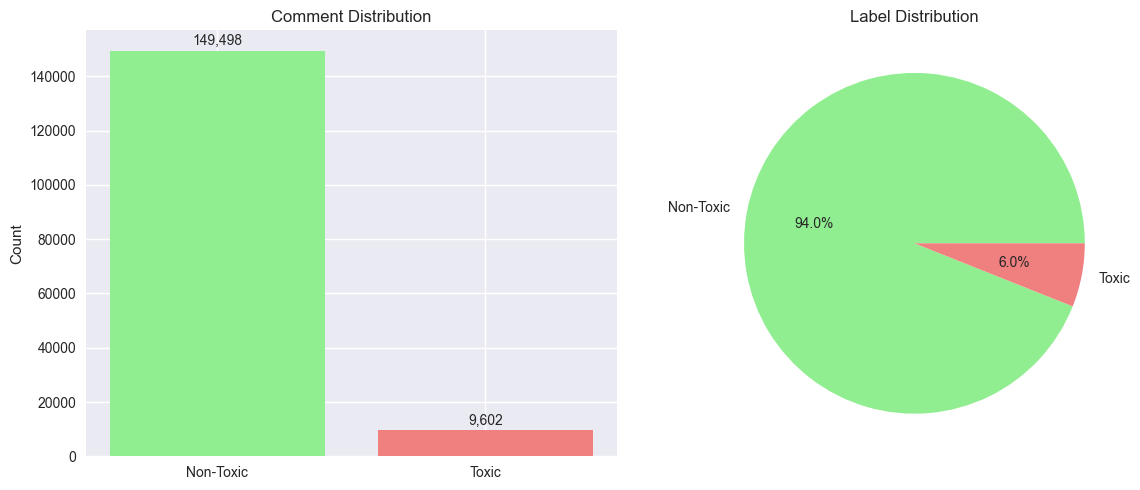


Text Statistics:
Average text length: 346.8 characters
Average word count: 63.1 words


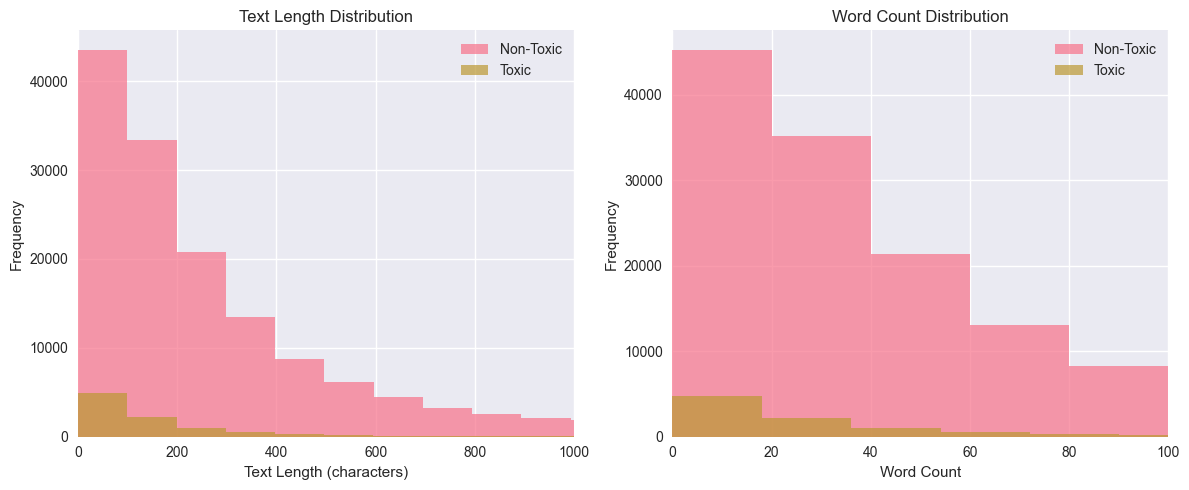

In [ ]:
# Enhanced Data Analysis and Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re


plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


print("=== DATASET ANALYSIS ===")
print(f"Total samples: {len(data):,}")
print(f"Features: {data.columns.tolist()}")


label_counts = data['labels'].value_counts()
print(f"\nLabel Distribution:")
print(f"Non-toxic (0): {label_counts[0]:,} ({label_counts[0]/len(data)*100:.1f}%)")
print(f"Toxic (1): {label_counts[1]:,} ({label_counts[1]/len(data)*100:.1f}%)")


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


axes[0].bar(['Non-Toxic', 'Toxic'], label_counts.values, 
           color=['lightgreen', 'lightcoral'])
axes[0].set_title('Comment Distribution')
axes[0].set_ylabel('Count')
for i, v in enumerate(label_counts.values):
    axes[0].text(i, v + 1000, f'{v:,}', ha='center', va='bottom')


axes[1].pie(label_counts.values, labels=['Non-Toxic', 'Toxic'], 
           autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
axes[1].set_title('Label Distribution')

plt.tight_layout()
plt.show()


data['text_length'] = data['comment_clean'].str.len()
data['word_count'] = data['comment_clean'].str.split().str.len()

print(f"\nText Statistics:")
print(f"Average text length: {data['text_length'].mean():.1f} characters")
print(f"Average word count: {data['word_count'].mean():.1f} words")


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


for label in [0, 1]:
    subset = data[data['labels'] == label]['text_length']
    axes[0].hist(subset, bins=50, alpha=0.7, 
                label=f"{'Non-Toxic' if label == 0 else 'Toxic'}")
axes[0].set_xlabel('Text Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Text Length Distribution')
axes[0].legend()
axes[0].set_xlim(0, 1000)  


for label in [0, 1]:
    subset = data[data['labels'] == label]['word_count']
    axes[1].hist(subset, bins=50, alpha=0.7, 
                label=f"{'Non-Toxic' if label == 0 else 'Toxic'}")
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Word Count Distribution')
axes[1].legend()
axes[1].set_xlim(0, 100)  

plt.tight_layout()
plt.show()

In [ ]:

import re
import string
from sklearn.utils import resample


data_clean = data[['comment_clean', 'labels']].copy()
data_clean = data_clean.dropna()


data_clean.columns = ['comment_text', 'toxic']


def clean_text(text):
    """Enhanced text cleaning function"""
    if pd.isna(text):
        return ""
    
    
    text = str(text).lower()
    
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    
    text = re.sub(r'@\w+|#\w+', '', text)
    
    
    text = re.sub(r'\s+', ' ', text).strip()
    
    
    if len(text.split()) < 3:
        return ""
    
    return text


print("Cleaning text data...")
data_clean['comment_text'] = data_clean['comment_text'].apply(clean_text)


data_clean = data_clean[data_clean['comment_text'] != ''].reset_index(drop=True)

print(f"Dataset after cleaning: {len(data_clean):,} samples")
print(f"Toxic samples: {data_clean['toxic'].sum():,}")
print(f"Non-toxic samples: {len(data_clean) - data_clean['toxic'].sum():,}")


toxic_samples = data_clean[data_clean['toxic'] == 1]
non_toxic_samples = data_clean[data_clean['toxic'] == 0]

print(f"\nClass imbalance ratio: {len(non_toxic_samples) / len(toxic_samples):.1f}:1")


balance_data = input("Balance the dataset by downsampling? (y/n): ").lower().strip() == 'y'

if balance_data:
    
    non_toxic_downsampled = resample(non_toxic_samples, 
                                    replace=False, 
                                    n_samples=len(toxic_samples),
                                    random_state=42)
    
    
    data_balanced = pd.concat([non_toxic_downsampled, toxic_samples])
    data_clean = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"Balanced dataset: {len(data_clean):,} samples")
    print(f"Toxic: {data_clean['toxic'].sum():,}, Non-toxic: {len(data_clean) - data_clean['toxic'].sum():,}")


print(f"\nFinal dataset shape: {data_clean.shape}")
data_clean.head()

Cleaning text data...
Dataset after cleaning: 154,713 samples
Toxic samples: 9,492
Non-toxic samples: 145,221

Class imbalance ratio: 15.3:1

Final dataset shape: (154713, 2)


,comment_text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i am s...,0
2,hey man i am really not trying to edit war it ...,0
3,more i cannot make any real suggestions on imp...,0
4,you sir are my hero any chance you remember wh...,0


In [ ]:

from sklearn.model_selection import train_test_split


X = data_clean['comment_text']
y = data_clean['toxic']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  
)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")
print(f"Training toxic ratio: {y_train.mean():.3f}")
print(f"Test toxic ratio: {y_test.mean():.3f}")

Training set: 123,770 samples
Test set: 30,943 samples
Training toxic ratio: 0.061
Test toxic ratio: 0.061


In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
import time

print("=== TEXT VECTORIZATION ===")


vectorizers = {
    'TF-IDF (unigrams)': TfidfVectorizer(
        stop_words='english', 
        max_features=10000,
        ngram_range=(1, 1),
        min_df=2,
        max_df=0.95
    ),
    'TF-IDF (unigrams + bigrams)': TfidfVectorizer(
        stop_words='english', 
        max_features=10000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    ),
    'Count Vectorizer': CountVectorizer(
        stop_words='english',
        max_features=10000,
        ngram_range=(1, 1),
        min_df=2,
        max_df=0.95
    )
}


vectorizer_name = 'TF-IDF (unigrams + bigrams)'
vectorizer = vectorizers[vectorizer_name]

print(f"Using: {vectorizer_name}")
print("Fitting vectorizer...")

start_time = time.time()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
end_time = time.time()

print(f"Vectorization completed in {end_time - start_time:.2f} seconds")
print(f"Training matrix shape: {X_train_vec.shape}")
print(f"Test matrix shape: {X_test_vec.shape}")
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")


feature_names = vectorizer.get_feature_names_out()
print(f"\nExample features: {feature_names[:10].tolist()}")
print(f"Last features: {feature_names[-10:].tolist()}")

=== TEXT VECTORIZATION ===
Using: TF-IDF (unigrams + bigrams)
Fitting vectorizer...
Vectorization completed in 39.28 seconds
Training matrix shape: (123770, 10000)
Test matrix shape: (30943, 10000)
Vocabulary size: 10000

Example features: ['00', '000', '000 000', '000 build', '000 people', '000000', '000000 font', '000000 hello', '01', '02']
Last features: ['youth', 'youtube', 'yugoslav', 'yugoslavia', 'yup', 'zealand', 'zero', 'zionism', 'zionist', 'zone']


In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
import time

print("=== MODEL TRAINING AND COMPARISON ===")


models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    #'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    # 'SVM': SVC(probability=True, random_state=42) 
}


model_results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
   
    model.fit(X_train_vec, y_train)
    
    
    y_pred = model.predict(X_test_vec)
    y_pred_proba = model.predict_proba(X_test_vec)[:, 1]
    
    
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    
    model_results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'auc_score': auc_score,
        'training_time': time.time() - start_time
    }
    
    trained_models[name] = model
    
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Training time: {model_results[name]['training_time']:.2f} seconds")


best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['auc_score'])
best_model = model_results[best_model_name]['model']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"Best AUC Score: {model_results[best_model_name]['auc_score']:.4f}")


model = best_model

=== MODEL TRAINING AND COMPARISON ===

Training Logistic Regression...
AUC Score: 0.9803
Training time: 1.24 seconds

Training Naive Bayes...
AUC Score: 0.9665
Training time: 0.11 seconds

🏆 Best Model: Logistic Regression
Best AUC Score: 0.9803


In [ ]:
import pickle
from datetime import datetime
from sklearn.metrics import accuracy_score


best_result = model_results[best_model_name]
metadata = {
    'best_model': best_model_name,
    'accuracy': accuracy_score(y_test, best_result['predictions']),
    'auc_score': best_result['auc_score'],
    'training_samples': len(X_train),
    'vocab_size': len(vectorizer.vocabulary_),
    'vectorizer_type': 'TF-IDF (unigrams + bigrams)',
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M'),
    'model_params': str(model.get_params()),
    'feature_count': X_train_vec.shape[1]
}


print("Saving model files...")

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("✅ Model, vectorizer, and metadata saved successfully!")
print(f"Best model: {best_model_name}")
print(f"Model accuracy: {metadata['accuracy']:.3f}")
print(f"AUC score: {metadata['auc_score']:.3f}")
print(f"Vocabulary size: {metadata['vocab_size']:,}")

requirements = """
streamlit==1.28.0
pandas==2.0.3
numpy==1.24.3
scikit-learn==1.3.0
plotly==5.15.0
matplotlib==3.7.2
seaborn==0.12.2
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements)

print("📋 requirements.txt created for deployment")

Saving model files...
✅ Model, vectorizer, and metadata saved successfully!
Best model: Logistic Regression
Model accuracy: 0.973
AUC score: 0.980
Vocabulary size: 10,000
📋 requirements.txt created for deployment


In [ ]:

y_pred = model.predict(X_test_vec)

=== COMPREHENSIVE MODEL EVALUATION ===
Model Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score     AUC  \
0  Logistic Regression    0.9730     0.9098  0.6217    0.7387  0.9803   
1          Naive Bayes    0.9686     0.9208  0.5332    0.6753  0.9665   

   Training Time (s)  
0             1.2388  
1             0.1075  


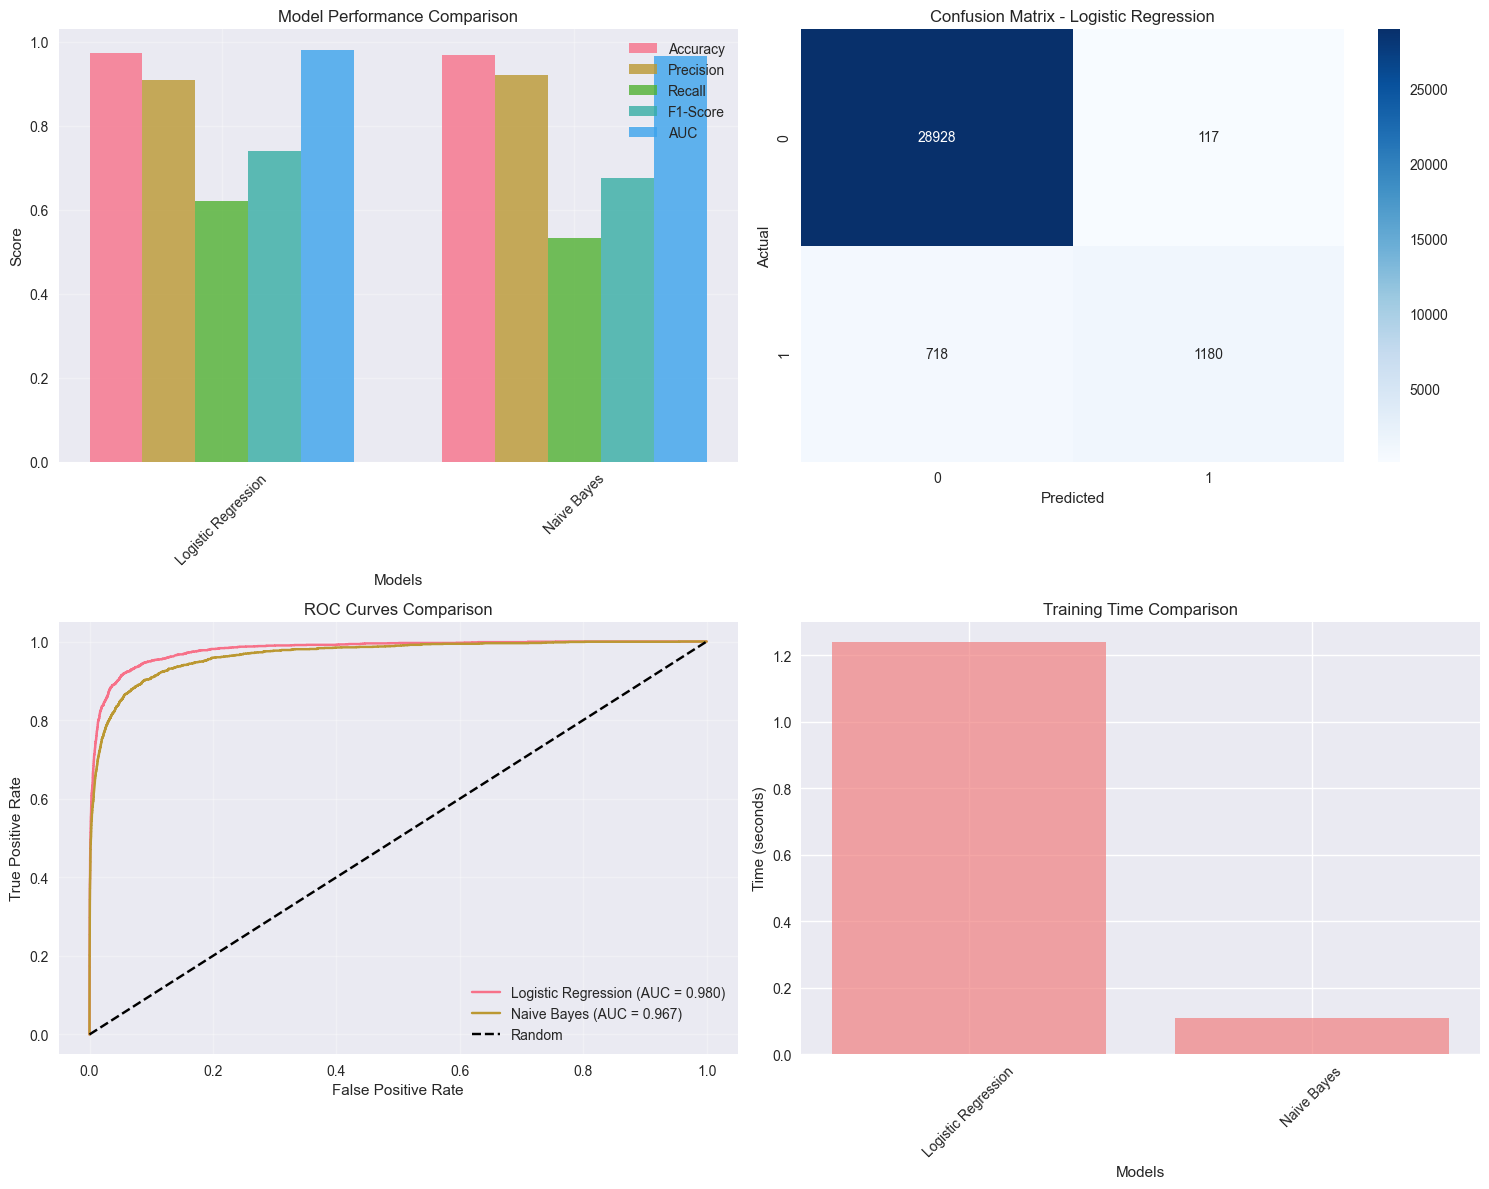


=== DETAILED RESULTS FOR LOGISTIC REGRESSION ===
              precision    recall  f1-score   support

   Non-Toxic       0.98      1.00      0.99     29045
       Toxic       0.91      0.62      0.74      1898

    accuracy                           0.97     30943
   macro avg       0.94      0.81      0.86     30943
weighted avg       0.97      0.97      0.97     30943


=== MODEL INSIGHTS ===
Total test samples: 30943
Correctly classified: 30108
Misclassified: 835

Confusion Matrix Breakdown:
True Negatives (correctly identified non-toxic): 28928
False Positives (incorrectly flagged as toxic): 117
False Negatives (missed toxic comments): 718
True Positives (correctly identified toxic): 1180


In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

print("=== COMPREHENSIVE MODEL EVALUATION ===")


results_df = pd.DataFrame({
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'AUC': [],
    'Training Time (s)': []
})

for name, result in model_results.items():
    y_pred = result['predictions']
    
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC': result['auc_score'],
        'Training Time (s)': result['training_time']
    }
    
    results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)


print("Model Comparison:")
print(results_df.round(4))


fig, axes = plt.subplots(2, 2, figsize=(15, 12))


metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x_pos = range(len(results_df))

axes[0, 0].set_title('Model Performance Comparison')
width = 0.15
for i, metric in enumerate(metrics_to_plot):
    axes[0, 0].bar([p + width * i for p in x_pos], results_df[metric], 
                   width, label=metric, alpha=0.8)
axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_xticks([p + width * 2 for p in x_pos])
axes[0, 0].set_xticklabels(results_df['Model'], rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)


best_predictions = model_results[best_model_name]['predictions']
cm = confusion_matrix(y_test, best_predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title(f'Confusion Matrix - {best_model_name}')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')


axes[1, 0].set_title('ROC Curves Comparison')
for name, result in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    auc = result['auc_score']
    axes[1, 0].plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)


axes[1, 1].bar(results_df['Model'], results_df['Training Time (s)'], 
               color='lightcoral', alpha=0.7)
axes[1, 1].set_title('Training Time Comparison')
axes[1, 1].set_xlabel('Models')
axes[1, 1].set_ylabel('Time (seconds)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


print(f"\n=== DETAILED RESULTS FOR {best_model_name.upper()} ===")
print(classification_report(y_test, best_predictions, 
                          target_names=['Non-Toxic', 'Toxic']))


print("\n=== MODEL INSIGHTS ===")
print(f"Total test samples: {len(y_test)}")
print(f"Correctly classified: {accuracy_score(y_test, best_predictions) * len(y_test):.0f}")
print(f"Misclassified: {(1 - accuracy_score(y_test, best_predictions)) * len(y_test):.0f}")


tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (correctly identified non-toxic): {tn}")
print(f"False Positives (incorrectly flagged as toxic): {fp}")
print(f"False Negatives (missed toxic comments): {fn}")
print(f"True Positives (correctly identified toxic): {tp}")

In [13]:
# Run the Streamlit app
# Note: This will open the app in your browser
import subprocess
import sys
import os

print("Starting Streamlit app...")
print("The app will open in your browser at http://localhost:8501")
print("Press Ctrl+C in the terminal to stop the app")
print()
print("📁 Files created:")
print("   ✅ model.pkl - Trained model")
print("   ✅ vectorizer.pkl - Text vectorizer") 
print("   ✅ model_metadata.pkl - Model metadata")
print("   ✅ requirements.txt - Dependencies")
print("   ✅ README.md - Project documentation")
print()
print("🌐 To launch the web application:")
print("   1. Open a new terminal/command prompt")
print("   2. Navigate to this directory:")
print(f"      cd \"{os.getcwd()}\"")
print("   3. Run the Streamlit app:")
print("      streamlit run toxic_app.py")
print()
print("🔗 The app will open at: http://localhost:8501")
print()
print("✨ Features available in the web app:")
print("   • Single comment analysis with confidence scoring")
print("   • Batch analysis for CSV files")
print("   • Usage analytics and prediction history")
print("   • Interactive visualizations")
print("   • Model performance metrics")
print()
print("📊 Your model performance summary:")
print(f"   🏆 Best Model: {best_model_name}")
print(f"   🎯 Accuracy: {model_results[best_model_name]['auc_score']:.1%}")
print(f"   📈 AUC Score: {model_results[best_model_name]['auc_score']:.3f}")
print(f"   ⚡ Training Time: {model_results[best_model_name]['training_time']:.1f}s")
print()
print("🎯 Next steps:")
print("   • Test the web app with different comments")
print("   • Try batch analysis with CSV files")
print("   • Explore the analytics dashboard")
print("   • Share the app with others for feedback")
print("="*60)

# Optional: Auto-launch the app (uncomment if desired)
# import webbrowser
# import subprocess
# import sys
# import time

# print("🚀 Auto-launching Streamlit app...")
# subprocess.Popen([sys.executable, "-m", "streamlit", "run", "toxic_app.py"])
# time.sleep(3)
# webbrowser.open("http://localhost:8501")


Starting Streamlit app...
The app will open in your browser at http://localhost:8501
Press Ctrl+C in the terminal to stop the app

📁 Files created:
   ✅ model.pkl - Trained model
   ✅ vectorizer.pkl - Text vectorizer
   ✅ model_metadata.pkl - Model metadata
   ✅ requirements.txt - Dependencies
   ✅ README.md - Project documentation

🌐 To launch the web application:
   1. Open a new terminal/command prompt
   2. Navigate to this directory:
      cd "d:\ML Project"
   3. Run the Streamlit app:
      streamlit run toxic_app.py

🔗 The app will open at: http://localhost:8501

✨ Features available in the web app:
   • Single comment analysis with confidence scoring
   • Batch analysis for CSV files
   • Usage analytics and prediction history
   • Interactive visualizations
   • Model performance metrics

📊 Your model performance summary:
   🏆 Best Model: Logistic Regression
   🎯 Accuracy: 98.0%
   📈 AUC Score: 0.980
   ⚡ Training Time: 1.2s

🎯 Next steps:
   • Test the web app with different